In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

import os
#from glob 
import glob
import itertools

import re
import pickle

In [2]:
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

In [3]:
DATA = './data'
MY_DATA = './my_data'
ANSW = './answers'

# ВАЖНО! РАБОТА СДЕЛАНА НА **PLOTLY**. ЕСЛИ НЕ ВКЛЮЧЕНЫ РАСШИРЕНИЯ У JUPYTER LAB, МОГУТ НЕКОРРЕКТНО ОТОБРАЖАТЬСЯ ГРАФИКИ. В ТАКОМ СЛУЧАЕ ОЦЕНКУ СЛЕДУЕТ ПРОИЗВОДИТЬ ПО HTML

## Часть 1. Построение признаков

- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

In [4]:
def prepare_train_set_with_fe(path_to_csv, site_freq_path, feature_names,
                                    sess_len=10, wind_size=10):
    
    rows = 0
    
    # load site freq indexes
    with open(site_freq_path, 'rb') as f:
        freq_site_dict = pickle.load(f)
    
    # getting size of output DataFrame
    for file_csv in (sorted(glob.glob(path_to_csv + '/*.csv'))):
        temp_dataframe = pd.read_csv(file_csv, usecols=['site'])
        #site_cnt += list(temp_dataframe.site.values)
        rows += round(temp_dataframe.shape[0] / wind_size + 0.499)
    
    ret_data = pd.DataFrame(index = range(rows), columns = feature_names)
    index = 0
    

    # prepare output DataFrame
    for file_csv in (sorted(glob.glob(path_to_csv + '/*.csv'))):
            temp_dataframe = pd.read_csv(file_csv, parse_dates=['timestamp'])
            userid = int(re.findall('\d+', file_csv)[1])

            #forming rows of output DataFrame
            sess_numb = round(temp_dataframe.shape[0] / wind_size + 0.499)
            for idx in range(sess_numb - 1):
                new_sess = {el:0 for el in feature_names}
                
                sess_start = idx*wind_size
                sess_end   = idx*wind_size + sess_len


                for n, idx in enumerate(range(sess_start,sess_end)):
                    new_sess['site' + str(n+1)] = freq_site_dict[temp_dataframe.loc[idx,'site']][0]
                    if idx < (sess_end - 1):
                        new_sess['time_diff' + str(n)] = (temp_dataframe.loc[idx + 1, 'timestamp'] - \
                                                temp_dataframe.loc[idx, 'timestamp']).total_seconds()
                
                
                new_sess['target'] = userid
                new_sess['#unique_sites'] = len(set(temp_dataframe.site.values[sess_start : sess_end]))
                new_sess['session_timespan'] = (temp_dataframe.loc[sess_end - 1, 'timestamp'] - \
                                                temp_dataframe.loc[sess_start, 'timestamp']).total_seconds() 
                new_sess['start_hour'] = temp_dataframe.loc[sess_start, 'timestamp'].hour 
                new_sess['day_of_week'] = temp_dataframe.loc[sess_start, 'timestamp'].weekday() 
                
                #put data in prepared DataFrame
                ret_data.iloc[index] = new_sess
                index += 1

                
            sess_start = idx*10
            sess_end   = temp_dataframe.shape[0]
            #forming las row of output DataFrame
            new_sess = {el:0 for el in feature_names}
            for n, idx in enumerate(range(sess_start,sess_end)):
                new_sess['site' + str(n+1)] = freq_site_dict[temp_dataframe.loc[idx,'site']][0]
                if idx < (sess_end - 1):
                    new_sess['time_diff' + str(n)] = (temp_dataframe.loc[idx + 1, 'timestamp'] - \
                                            temp_dataframe.loc[idx, 'timestamp']).total_seconds()
            new_sess['target'] = userid
            new_sess['#unique_sites'] = len(set(temp_dataframe.site.values[(sess_numb-1)*wind_size: ]))

            new_sess['session_timespan'] = (temp_dataframe.iloc[-1].timestamp - \
                                            temp_dataframe.loc[(sess_numb-1)*wind_size, 'timestamp']).total_seconds()
            new_sess['start_hour'] = temp_dataframe.loc[(sess_numb-1)*wind_size, 'timestamp'].hour  
            new_sess['day_of_week'] = temp_dataframe.loc[(sess_numb-1)*wind_size, 'timestamp'].weekday()    
                
            #ret_userid_list.append(userid)

            ret_data.iloc[index] = new_sess
            index += 1
            
            
            
            
    return ret_data

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

In [6]:
train_data_toy  = prepare_train_set_with_fe(os.path.join(DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(MY_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, sess_len=10)

In [7]:
train_data_toy.head(5)

site1 site2 site3 site4 site5 site6 site7 site8 site9 site10  ...  \
0     3     2     2     7     2     1     8     5     9     10  ...   
1     0     0     0     0     0     0     0     0     0      0  ...   
2     0     0     0     0     0     0     0     0     0      0  ...   
3     4     1     2     1     2     1     1     5    11      4  ...   
4     0     0     0     0     0     0     0     0     0      0  ...   

  time_diff5 time_diff6 time_diff7 time_diff8 time_diff9 session_timespan  \
0          1          2          3         55          0             7998   
1          0          0          0          0          0               60   
2          0          0          0          0          0             7935   
3          1          2          3         55          0             7998   
4          0          0          0          0          0             1471   

  #unique_sites start_hour day_of_week target  
0             8          9           4      1  
1             2         12           4      1  
2             3          9           4      2  
3             5          9           4      3  
4             3         12           4      3  

[5 rows x 24 columns]

соответствует приведенному в задании для сравнения

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(MY_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, sess_len=10)

CPU times: user 15.1 s, sys: 38.4 ms, total: 15.1 s
Wall time: 15 s


In [9]:
train_data_10users.head()

site1 site2 site3 site4 site5 site6 site7 site8 site9 site10  ...  \
0   192   574   133     3   133   133     3   133   203    133  ...   
1   415   193   674   254   133    31   393  3305   217     55  ...   
2    55     3    55    55     5   293   415   333   897     55  ...   
3   473  3306   473    55    55    55    55   937   199    123  ...   
4   342    55     5  3307   258   211  3308  2086   675   2086  ...   

  time_diff5 time_diff6 time_diff7 time_diff8 time_diff9 session_timespan  \
0          1          0          1          0          0               33   
1          1          3          3          8          0              284   
2          0          1          0          0          0              258   
3          1          0          0          0          0               30   
4          0          1          1          0          0                6   

  #unique_sites start_hour day_of_week target  
0             5          8           4     31  
1            10          8           4     31  
2             7          8           4     31  
3             6          8           4     31  
4             9          8           4     31  

[5 rows x 24 columns]

In [10]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(MY_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, sess_len=10)

train_data_150users.head()

CPU times: user 2min 29s, sys: 232 ms, total: 2min 29s
Wall time: 2min 29s


site1 site2 site3 site4 site5 site6 site7 site8 site9 site10  ...  \
0     1     1     4     2     1     4     1     2  1290    321  ...   
1     2    23  1505  1290   321   321   113    73    49     49  ...   
2   321   205     1     1     1     1    73   321     2      1  ...   
3     1     1  6998  6998  5491  6998  6998     1    35      1  ...   
4     1     1    76     1    58    50    58    50    83     76  ...   

  time_diff5 time_diff6 time_diff7 time_diff8 time_diff9 session_timespan  \
0          1          0         49          0          0               57   
1         73          0       1504          4          0             1618   
2         56       1917          0          4          0             2010   
3        420       1460          6          0          0             2006   
4          1          0          1          0          0               10   

  #unique_sites start_hour day_of_week target  
0             5          8           4      6  
1             8          8           4      6  
2             5          8           4      6  
3             4          9           4      6  
4             5          9           4      6  

[5 rows x 24 columns]

In [11]:
print(feature_names)

['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10', 'time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5', 'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9', 'session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']


In [12]:
NEW_FEATURES = [ 'time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5', 'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9', \
                'session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

In [13]:
with open(os.path.join(MY_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(train_data_150users[NEW_FEATURES], new_features_10users_pkl)
with open(os.path.join(MY_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(train_data_150users[NEW_FEATURES], new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

In [14]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [15]:
train_data_10users.head()

site1 site2 site3 site4 site5 site6 site7 site8 site9 site10  ...  \
0   192   574   133     3   133   133     3   133   203    133  ...   
1   415   193   674   254   133    31   393  3305   217     55  ...   
2    55     3    55    55     5   293   415   333   897     55  ...   
3   473  3306   473    55    55    55    55   937   199    123  ...   
4   342    55     5  3307   258   211  3308  2086   675   2086  ...   

  time_diff5 time_diff6 time_diff7 time_diff8 time_diff9 session_timespan  \
0          1          0          1          0          0               33   
1          1          3          3          8          0              284   
2          0          1          0          0          0              258   
3          1          0          0          0          0               30   
4          0          1          1          0          0                6   

  #unique_sites start_hour day_of_week target  
0             5          8           4   John  
1            10          8           4   John  
2             7          8           4   John  
3             6          8           4   John  
4             9          8           4   John  

[5 rows x 24 columns]

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**гистограмма распределения длины сессии в секундах**

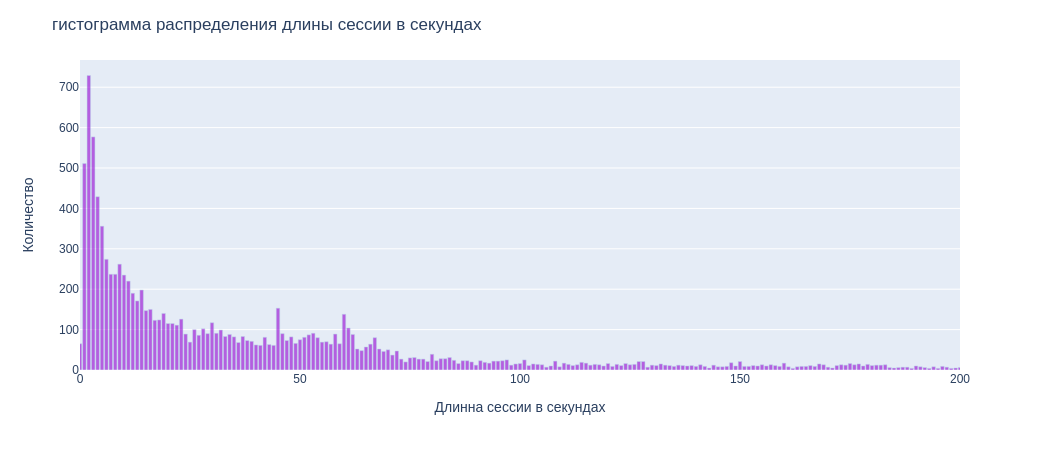

In [17]:
fig = px.bar(x = train_data_10users['session_timespan'].value_counts().keys(),
             y = train_data_10users['session_timespan'].value_counts()
                   , range_x = [0, 200]
            )
fig.update_traces(marker_color='darkviolet', marker_line_color='rgb(158,202,225)',
                  marker_line_width=0.5, opacity=0.6)
fig.update_layout(
    title=u'гистограмма распределения длины сессии в секундах',
    xaxis_title=u'Длинна сессии в секундах',
    yaxis_title=u'Количество',
    )
fig.show()

гистограмма распределения числа уникальных сайтов в сессии

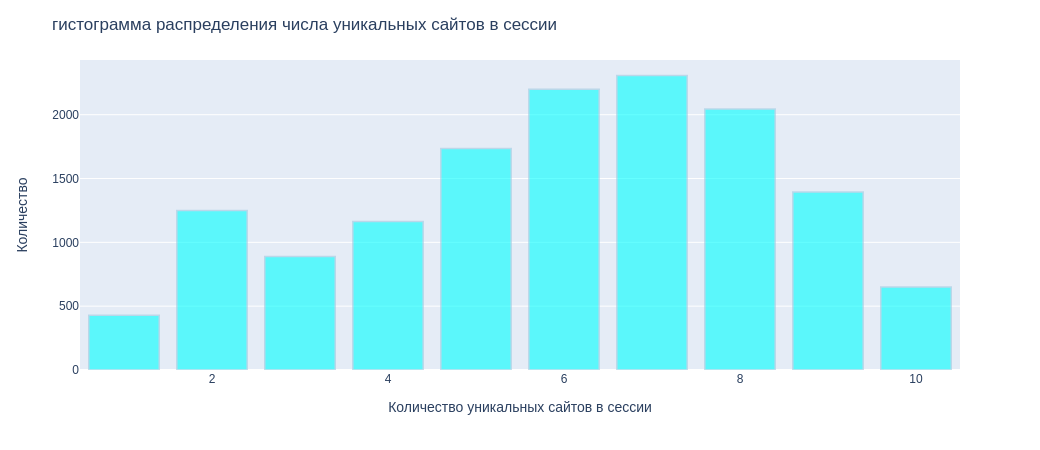

In [18]:
fig = px.bar(x = train_data_10users['#unique_sites'].value_counts().keys(),
             y = train_data_10users['#unique_sites'].value_counts(), 
)

fig.update_traces(marker_color='aqua',
                  marker_line_color = 'rgb(158,202,225)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(
    title=u'гистограмма распределения числа уникальных сайтов в сессии',
    xaxis_title=u'Количество уникальных сайтов в сессии',
    yaxis_title=u'Количество ',
    )
fig.show()

гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей

In [19]:
# plot figure for one user with description 
def subplot_data(used_fig, inp_data, user_uniq, row, col, ftr, ttl):
    
    idxs = inp_data.target == user_uniq
    new_fig = go.Bar(y = inp_data.loc[idxs, ftr].value_counts(),
                      x = inp_data.loc[idxs, ftr].value_counts().keys()
                    , name = user_uniq
                    )
    used_fig.append_trace( new_fig,
                    row=row+1, col=col+1
                    )
    used_fig.update_traces(marker_color=color_dic[user_uniq], 
                        marker_line_color='red',
                  marker_line_width=1.5, opacity=0.6,
                     row=row+1, col=col+1)
    
    used_fig.update_xaxes(title_text=ttl + user_uniq, 
                       row=row+1, col=col+1)
    used_fig.update_yaxes(title_text='кол-во', 
                       row=row+1, col=col+1)
    
    return used_fig

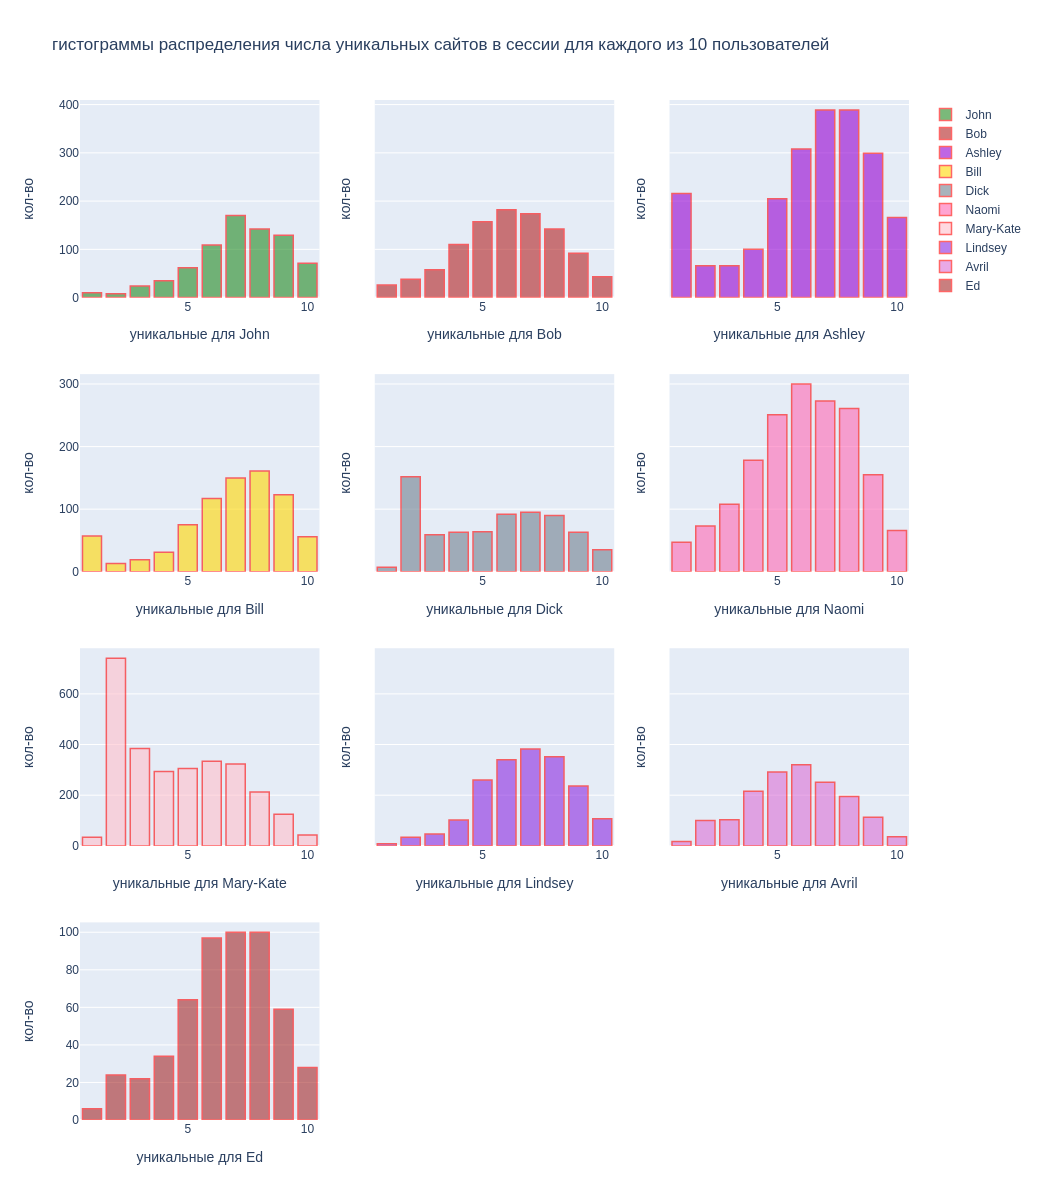

In [20]:
fig10 = make_subplots(rows=4, cols=3, shared_yaxes=True)

users = train_data_10users.target.unique()
for el in itertools.product(range(3), repeat = 2):
    # (used_fig, inp_data, user_uniq, row, col)
    fig10 = subplot_data(fig10, train_data_10users, 
                users[el[0]*3 + el[1]], 
                el[0], el[1],
                '#unique_sites',
                'уникальные для ')
    
fig10 = subplot_data(fig10, train_data_10users, users[9], 
                3, 0, '#unique_sites', 'уникальные для ')

fig10.update_layout(height=1200, width=1000, title_text='гистограммы распределения числа уникальных' + \
                                   ' сайтов в сессии для каждого из 10 пользователей')      
fig10.show()

гистограмма распределения часа начала сессии (start_hour)

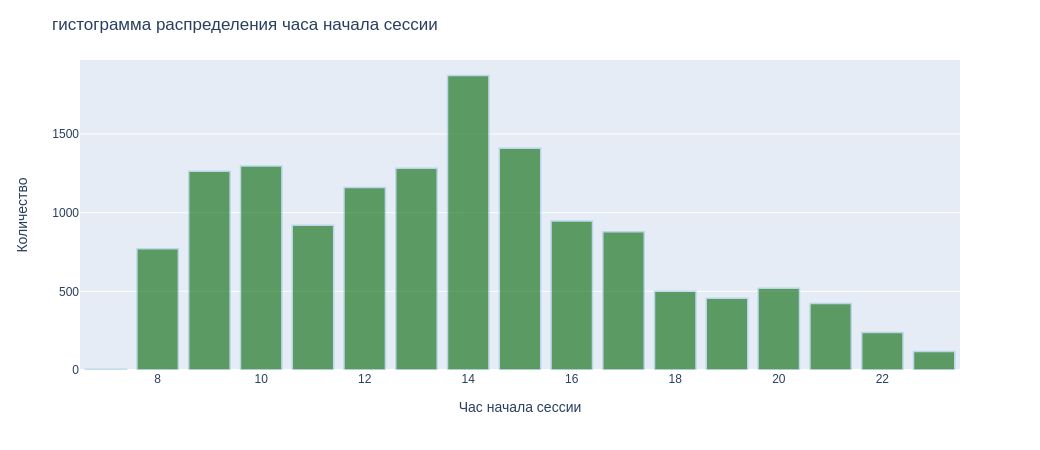

In [21]:
fig = px.bar(x = train_data_10users['start_hour'].value_counts().keys(),
             y = train_data_10users['start_hour'].value_counts(),        
            )
fig.update_traces(marker_color='darkgreen', marker_line_color='rgb(158,202,225)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(
    title=u'гистограмма распределения часа начала сессии',
    xaxis_title=u'Час начала сессии',
    yaxis_title=u'Количество ',
    )
fig.show()

In [22]:
train_data_10users['start_hour'].value_counts()

14.0    1872
15.0    1409
10.0    1297
13.0    1283
9.0     1264
12.0    1160
16.0     947
11.0     920
17.0     879
8.0      770
20.0     519
18.0     500
19.0     456
21.0     423
22.0     239
23.0     118
7.0        5
Name: start_hour, dtype: int64

гистограмма распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей

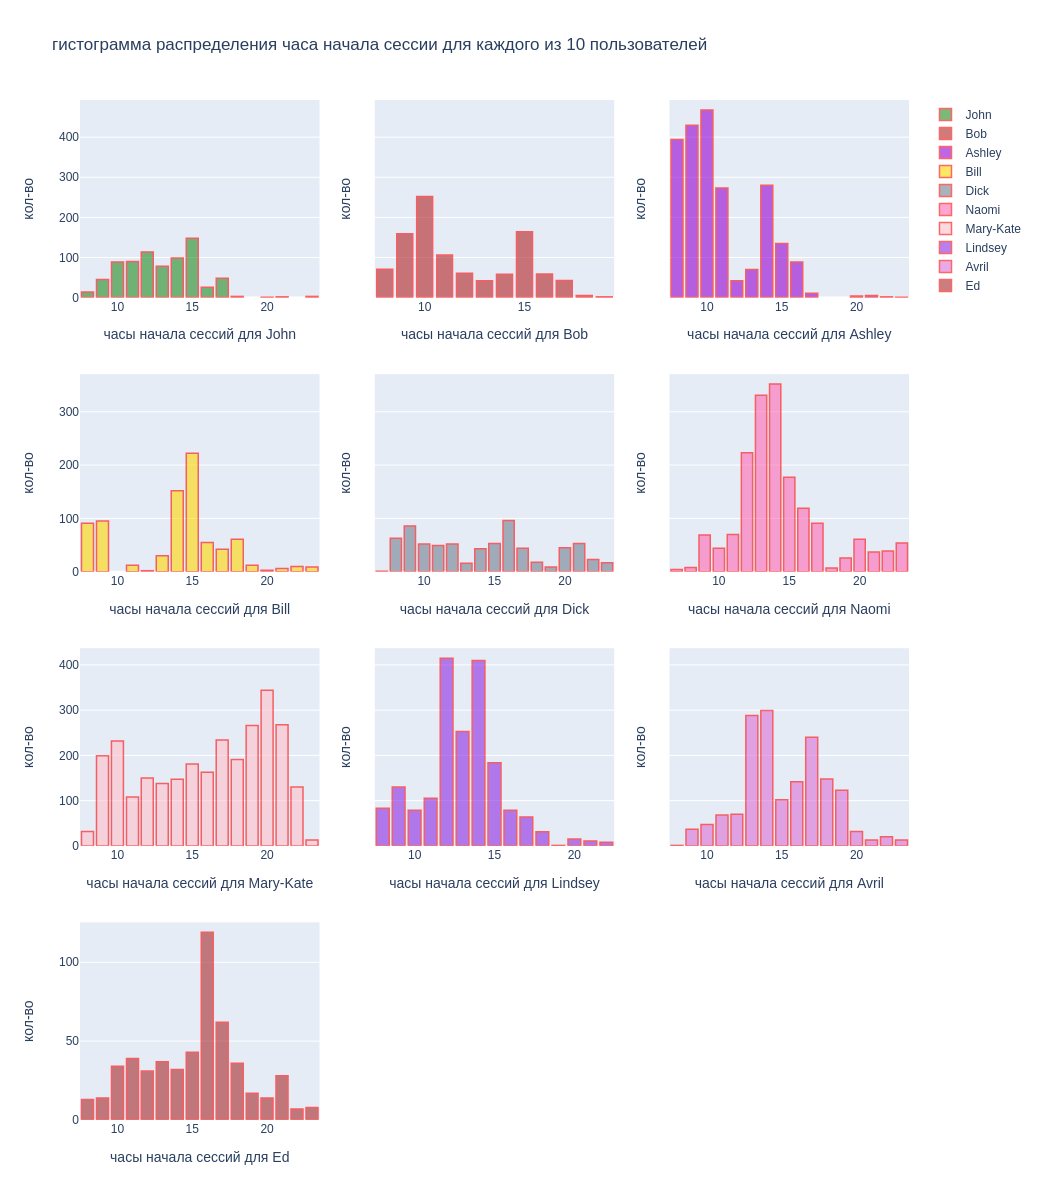

In [23]:
fig10 = make_subplots(rows=4, cols=3, shared_yaxes=True)

users = train_data_10users.target.unique()
for el in itertools.product(range(3), repeat = 2):
    # (used_fig, inp_data, user_uniq, row, col)
    fig10 = subplot_data(fig10, train_data_10users, 
                users[el[0]*3 + el[1]], 
                el[0], el[1],
                'start_hour',
                'часы начала сессий для ')
    
fig10 = subplot_data(fig10, train_data_10users, users[9], 
                3, 0, 'start_hour', 'часы начала сессий для ')

fig10.update_layout(height=1200, width=1000, 
                    title_text='гистограмма распределения часа начала сессии ' +\
                    'для каждого из 10 пользователей')      
fig10.show()

гистограмма распределения дня недели, в который началась сессия

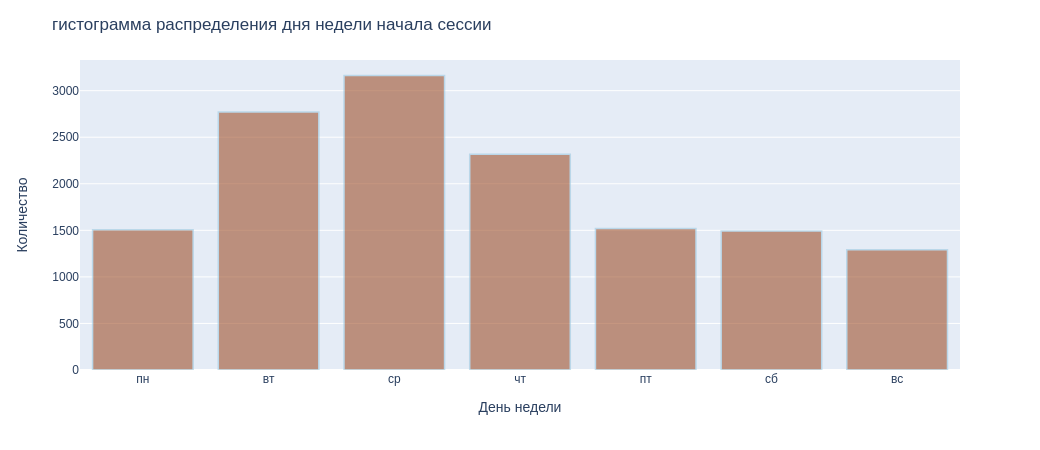

In [24]:
fig = px.bar(x = train_data_10users['day_of_week'].value_counts().keys(),
             y = train_data_10users['day_of_week'].value_counts(),         
            )
fig.update_traces(marker_color='sienna', marker_line_color='rgb(158,202,225)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(
    title=u'гистограмма распределения дня недели начала сессии',
    xaxis_title=u'День недели',
    yaxis_title=u'Количество ',
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1, 2, 3, 4, 5, 6],
        ticktext = ['пн','вт','ср','чт','пт','сб','вс']
    )
    )
fig.show()

In [25]:
train_data_10users['day_of_week'].value_counts()

2.0    3163
1.0    2772
3.0    2316
4.0    1520
0.0    1505
5.0    1494
6.0    1291
Name: day_of_week, dtype: int64

гистограмма распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей

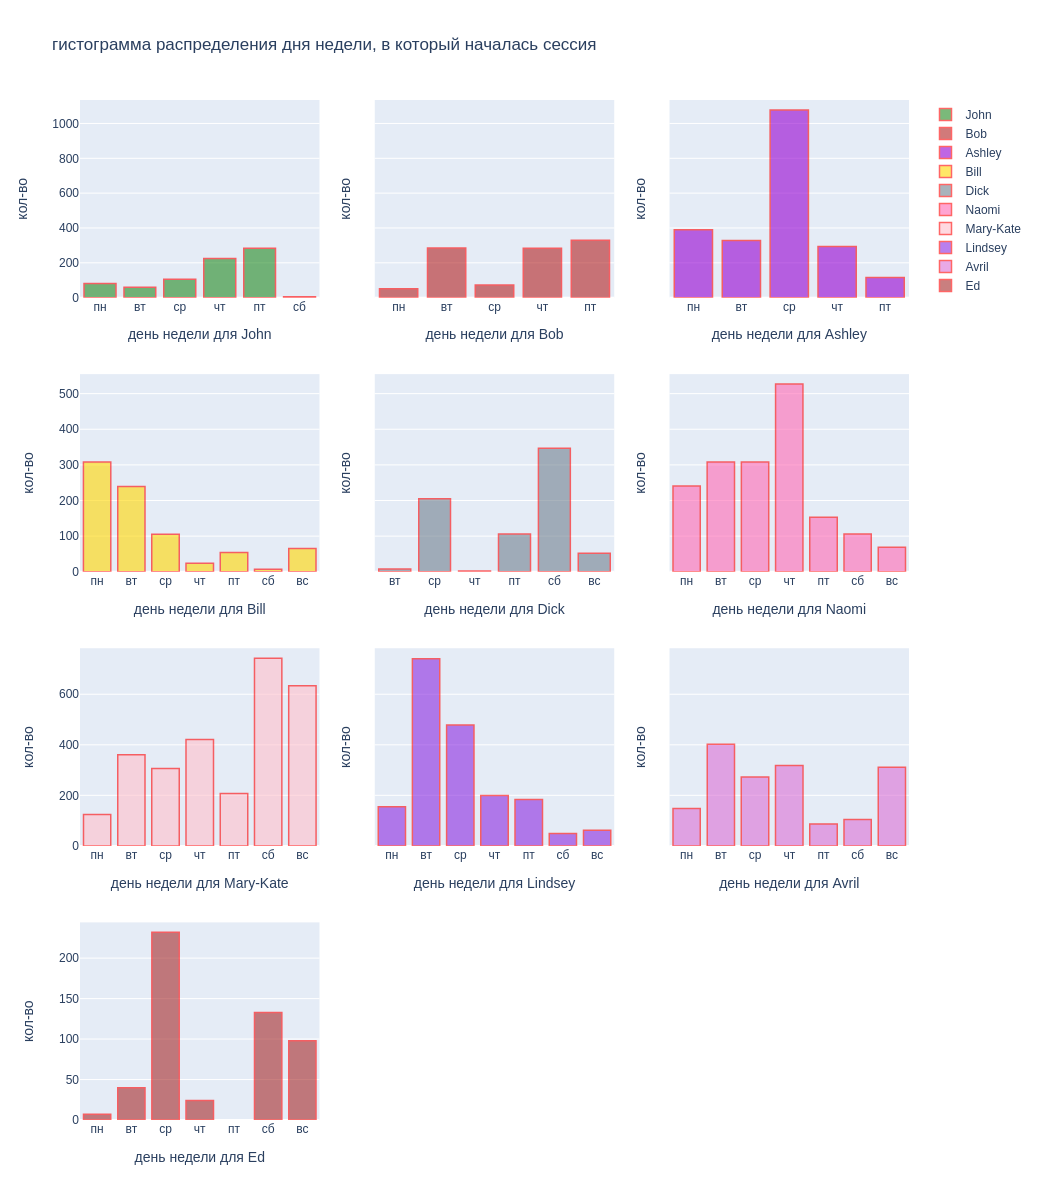

In [26]:
#dof_dict = {0:'пн', 1:'вт', 2:'ср', 3:'чт', 4:'пт', 5:'сб', 6:'вс'}
#train_data_10users['dof'] = train_data_10users['day_of_week'].apply(lambda x: dof_dict[x])

fig10 = make_subplots(rows=4, cols=3, shared_yaxes=True)

users = train_data_10users.target.unique()
for el in itertools.product(range(3), repeat = 2):
    # (used_fig, inp_data, user_uniq, row, col)
    fig10 = subplot_data(fig10, train_data_10users, 
                users[el[0]*3 + el[1]], 
                el[0], el[1],
                'day_of_week',
                #'dof',
                'день недели для ')
    
fig10 = subplot_data(fig10, train_data_10users, users[9], 
                3, 0, 
                'day_of_week', 
                #'dof',
                'день недели для ')

fig10.update_xaxes(#xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1, 2, 3, 4, 5, 6],
        ticktext = ['пн','вт','ср','чт','пт','сб','вс'],
    #),
                   )

fig10.update_layout(height=1200, width=1000, 
                    title_text=u'гистограмма распределения дня недели, ' + \
                    'в который началась сессия'

                    )      
fig10.show()

выводы про каждого пользователя по построенным графикам

**John:**  сессии в основном в будни в рабочее время. количество уникальных сайтов в сессии    
визуально распределено нормально и относительно мало.

**Bob:** сессии в будние дни в рабочее время. 2 пика активности в течении дня - 10 и 15 часов.    
Больше активности к концу недели.    
Количество уникальных сайтов в сессии визуально распределено нормально и относительно мало.

**Ashley:** сессии в будние дни в рабочее время с редкими заходами после 20:00. (Переработка?)    
2 пика активности в четечни  дня 10 и 14 часов. Упор на утенние часы.  
Количество уникальных сайтов в сесии визуально распределено нормально     
с тяжелым хвостом (выбросом) в 1 - много сессии с одним сайтом (соц.сети / почта / погода?)    
Относительно большое число сессий.

**Bill:** сессии во все дни недели с упором на начало недели. В основном в рабочее время    
с пиками в 8-9 и 15. Малое количество сессий после 20:00.   
Количество уникальных сайтов в сесии визуально распределено нормально     
с несколько тяжелым хвостом в 1 - много сессии с одним сайтом (соц.сети / почта / погода?)    
Относительно малое число сессий.

**Dick:** сессии во все дни недели с уклоном на выходные. В будни выбивается только среда.    
Время начала сессиий либо равномерно, либо является суммой 3х нормальных распределиний с пиками    
в 9, 16 и 21 час. Более определенно сказать из графика не представляется возможным.    
Количество уникальных сайтов в сесии визуально распределено нормально с большой сигма    
и очень тяжелым хвостом (выбросом) в 2 - много сессии с двумя сайтами (соц.сети / почта / новости?)    
Относительно малое число сессий.

**Naomi:** сессии во все дни, визуально с нормальным распределением.    
Часы начала сессий преимущественно в рабочее время. Визуально распределены    
нормально, либо состоящие из 2-х нормальных с пиками в 16 и 20 часов.    
Количество уникальных сайтов в сессии визуально распределено нормально.

**Mary-Kate:** сесии во все дни недели с перевесом на выходные.    
Время начала сессий визуально распределено нормально с пиком в 20:00    
и тяжелыми хвостами (выбросом) в 9-10 часов.    
Количество уникальных сайтов имеет пик в 2-3. Много сессий с малым    
количеством уникальных сайтов (соц.сети / почта / новости?)    
Относительно большое количество сессий.

**Lindsey:** сессии во все дни недели с упором на начало недели.    
Часы начала сессии визуально распределены нормально с пиком в середине дня.    
Количество уникальных сайтов в сессии визуально распределено нормально и    
относительно велико.

**Avril:** сессии во все дни недели относительно равномерно.    
время начала сессий распределено нормально с пиком в 17 часов и    
выбросами в 13 и 14 часов.    
Количество уникальных сайтов визуально распределено нормально.

**Ed:** сессии почти во все дни недели с пиками в среду и на выходных.    
Часы начала сессий визуально распределены нормально с пиком в 16 часов.    
Количество уникальных сайтов в сессии визуально распределено нормально и    
мало.

**ключевой вывод о графикам - идентификация пользователей по представленным данным    
возможна и с хорошим результатом.**

**Определяем топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [27]:
with open(os.path.join(MY_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    freq_site_dict = pickle.load(f)

In [28]:
top10_freqs = [el[1][1] for el in freq_site_dict.items()][:10]
top10_sites = [el[0] for el in freq_site_dict.items()][:10]

In [29]:
top10_freqs

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]

In [30]:
print(top10_sites)

['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']


**Отобразим частоты посещений топ-10 сайтов**

т.к. в начале указано    
*Если задействуете IPython-виджеты, библиотеку Plotly, анимации     
и прочий интерактив, всем от этого будет только лучше.*    
вместо seaborn, как и ранее, используем Plotly

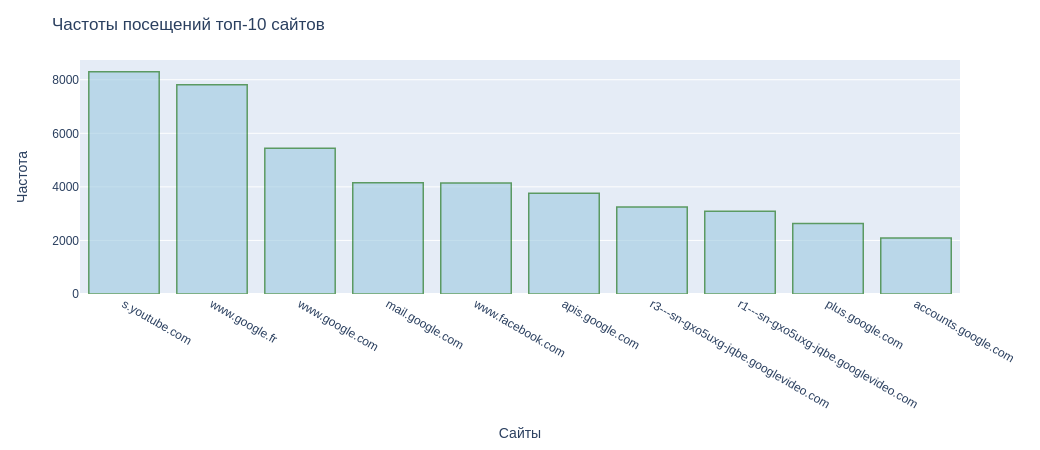

In [31]:
fig = px.bar( x = top10_sites
             , y = top10_freqs
            )
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='darkgreen',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(
    title=u'Частоты посещений топ-10 сайтов',
    xaxis_title=u'Сайты',
    yaxis_title=u'Частота ',
    )
fig.show()

## Часть 3. Проверка построенных признаков

**медианная продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [32]:
train_data_10users.session_timespan.median()

37.0

**медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [33]:
train_data_10users.day_of_week.median()

2.0

**медианный час начала сессии для сессий 150 пользователей.**

In [34]:
train_data_150users.start_hour.median()

13.0

**медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [35]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

При построении признаков будем иходить из того, что необходимо идентифицировать 150-3000    
пользователей. Следовательно, числовым и категориальным признакам отдается предпочтение    
при оценке трудозатрат на построение признака и ожидаемой отдачи по сравнению с бинарными.

In [36]:
print(feature_names)

['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10', 'time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5', 'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9', 'session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']


Как мы видим данные у нас начинаются с 7-8 утра. Т.о. мы достаточно точно можем отделить    
начало дня и первый посещенный пользователем сайт. Сам сайт нам ничего не даст, т.к. их    
бесконечное количество (мы же не планируем все сайты делать категориальными признаками).    
Мы можем получить метрики для пользователя: среднее значение и среднеквадратичное    
отклонение времени первого в день сайта пользователя, времени, проведенного на них.    
Как я понимаю такие характеристики сильно характеризуют пользователей при достаточном обьеме    
данных. 
При малом количестве данных (например если брать игрушечный пример на 3 пользователя),    
можно разделить сессии по перерыву между посещением сайтов, и считать вышеприведенные метрики    
для первых сайтов в этих сессиях. При этом длительность перерыва - гиперпараметр.

In [37]:
def new_metrics(inp_data, border, ):

    cur_day = -1
    
    first_day_site  = []         # first site of the day
    first_day_site_duration = [] # duration on first site of the day
    
    first_sess_site = []         # first site in session
    first_sess_site_duration = []# duration on first site in session
    
    first_connect_in_day_time = []# time of enter at the first site of the day
    
    
    for idx in range(inp_data.timestamp.shape[0] - 1):
        # check for our own *session*
        if (inp_data.loc[idx+1, 'timestamp'] - inp_data.loc[idx, 'timestamp']) > border:
            first_sess_site.append(inp_data.loc[idx+1, 'site'])
            # if last site in the session - can't determine his duration
            if (idx+2) < inp_data.timestamp.shape[0] and \
                 (inp_data.loc[idx+2, 'timestamp'].day == inp_data.loc[idx+1, 'timestamp'].day):
                first_sess_site_duration.append((inp_data.loc[idx+2, 'timestamp'] - \
                                    inp_data.loc[idx+1, 'timestamp']).total_seconds())
            else:
                first_sess_site_duration.append(0)
            
        # first site of the day
        if inp_data.loc[idx, 'timestamp'].day != cur_day:
            first_day_site.append(inp_data.loc[idx, 'site'])
            first_connect_in_day_time.append(
                inp_data.loc[idx, 'timestamp'].hour * 60 + inp_data.loc[idx, 'timestamp'].minute)
            cur_day = inp_data.loc[idx, 'timestamp'].day
            # if last site at the day - can't determine his duration
            if (inp_data.timestamp.shape[0] > 1) and \
                (inp_data.loc[idx, 'timestamp'].day == inp_data.loc[idx+1, 'timestamp'].day):
                first_day_site_duration.append((inp_data.loc[idx+1, 'timestamp'] - \
                                    inp_data.loc[idx, 'timestamp']).total_seconds())
            else:
                first_day_site_duration.append(0)
    

    ret_dict = {
               'first_day_site_same': len(set(first_day_site)) == 1,
               'first_sess_site_same': len(set(first_sess_site)) == 1,
        
               'first_day_site_duration_mean': np.mean(first_day_site_duration),
               'first_sess_site_duration_mean': np.mean(first_sess_site_duration),
               'first_connect_in_day_time_mean': np.mean(first_connect_in_day_time),
                
               'first_day_site_duration_std': np.std(first_day_site_duration),
               'first_sess_site_duration_std': np.std(first_sess_site_duration),
               'first_connect_in_day_time_std': np.std(first_connect_in_day_time),
               }
    
    return ret_dict

In [38]:
add_features = ['first_day_site_same',
 'first_sess_site_same',
 'first_day_site_duration_mean',
 'first_sess_site_duration_mean',
 'first_connect_in_day_time_mean',
 'first_day_site_duration_std',
 'first_sess_site_duration_std',
 'first_connect_in_day_time_std',
 'userid']

In [39]:
def create_additional_features(path_to_csv, inp_border):
    
    
    ret_data = pd.DataFrame(index = range(len(glob.glob(os.path.join(path_to_csv, '*.csv')))), 
                        columns = add_features)
    
    for idx, el in enumerate(glob.glob(os.path.join(path_to_csv, '*.csv'))):
        tmp_data = pd.read_csv(el, parse_dates=['timestamp'])
        
        inst_dict = new_metrics(tmp_data, inp_border)
        ret_data.loc[idx] = inst_dict
        ret_data.loc[idx, 'userid'] = int(re.findall('\d+', el)[1])
        
    return ret_data

In [40]:
%%time
#border = np.timedelta64(1, 'h')
border = np.timedelta64(30, 'm')
new_data = create_additional_features(os.path.join(DATA, '10users'), border)

CPU times: user 7.14 s, sys: 16 ms, total: 7.15 s
Wall time: 7.16 s


In [41]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
new_data['userid'] = new_data['userid'].map(id_name_dict)

In [42]:
new_data.iloc[:, 2:]

first_day_site_duration_mean first_sess_site_duration_mean  \
0                       40.775                       46.7119   
1                      324.655                        427.25   
2                      1052.17                       929.338   
3                       158.91                       214.773   
4                      460.282                       311.444   
5                      1092.71                       806.466   
6                      102.139                       103.185   
7                      450.941                       800.578   
8                      160.508                       210.545   
9                      372.267                        580.25   

  first_connect_in_day_time_mean first_day_site_duration_std  \
0                         624.05                     128.303   
1                        917.345                     1116.28   
2                        775.861                     4289.12   
3                        814.493                     818.774   
4                            721                     2399.05   
5                        814.174                     4175.94   
6                        780.611                     228.504   
7                        673.147                     1337.59   
8                        718.905                     681.657   
9                        1028.17                     1057.76   

  first_sess_site_duration_std first_connect_in_day_time_std     userid  
0                      124.502                       188.375     Ashley  
1                      1959.04                       242.255         Ed  
2                      3744.98                       219.273  Mary-Kate  
3                      956.636                       215.927      Naomi  
4                      1801.92                       145.583       John  
5                      3328.95                        182.89      Avril  
6                      253.385                       231.222       Bill  
7                      2332.58                       162.897        Bob  
8                      1164.21                       215.225    Lindsey  
9                      1898.09                       236.298       Dick

Визуализиуем:    
Сами значения визуально не столь информативны. Отобразим сразу по 2 значения на графике:    
нормальное распределение с параметрами, соответствующим полученным для каждого пользователя.


In [43]:
def subplot_features_points(used_fig, inp_data, ftr, idx, row, col):
    inp_x = np.linspace(inp_data.loc[idx, ftr+'_mean'] - 3*inp_data.loc[idx, ftr+'_std'],
                        inp_data.loc[idx, ftr+'_mean'] + 3*inp_data.loc[idx, ftr+'_std'])

    rv = norm(inp_data.loc[idx, ftr+'_mean'], inp_data.loc[idx, ftr+'_std'])
    
    
    used_fig.append_trace( go.Scatter(y = rv.pdf(inp_x), 
                                      x = inp_x, 
                                      mode = 'lines',
                                      name = inp_data.loc[idx, 'userid']),
                            row=row+1, col=col+1
                         )
    
    used_fig.update_xaxes(title_text= inp_data.loc[idx, 'userid'], 
                       row=row+1, col=col+1)

    
    return used_fig

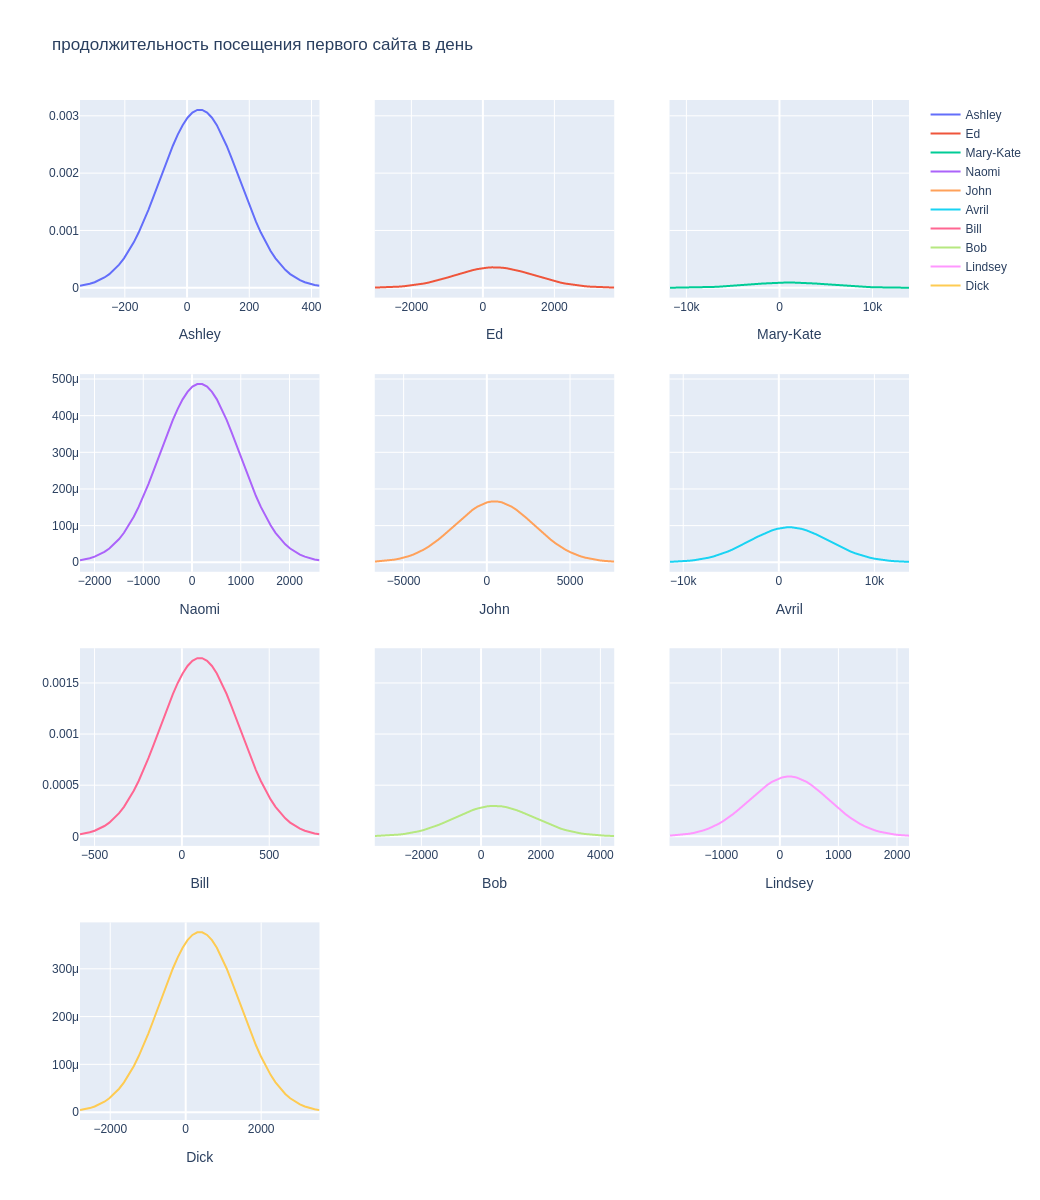

In [44]:
fig10 = make_subplots(rows=4, cols=3, shared_yaxes=True)
#fig10 = make_subplots(rows=4, cols=3)


for el in itertools.product(range(3), repeat = 2):
    fig10 = subplot_features_points(fig10, new_data, 
                'first_day_site_duration', 
                idx = el[0]*3 + el[1],
                row = el[0], col = el[1]
                )
    
fig10 = subplot_features_points(fig10, new_data, 
                'first_day_site_duration', 
                idx = 9, row = 3, col = 0
                )

fig10.update_layout(height=1200, width=1000, 
                    title_text=u'продолжительность посещения первого сайта в день'
                    ) 
fig10.show()

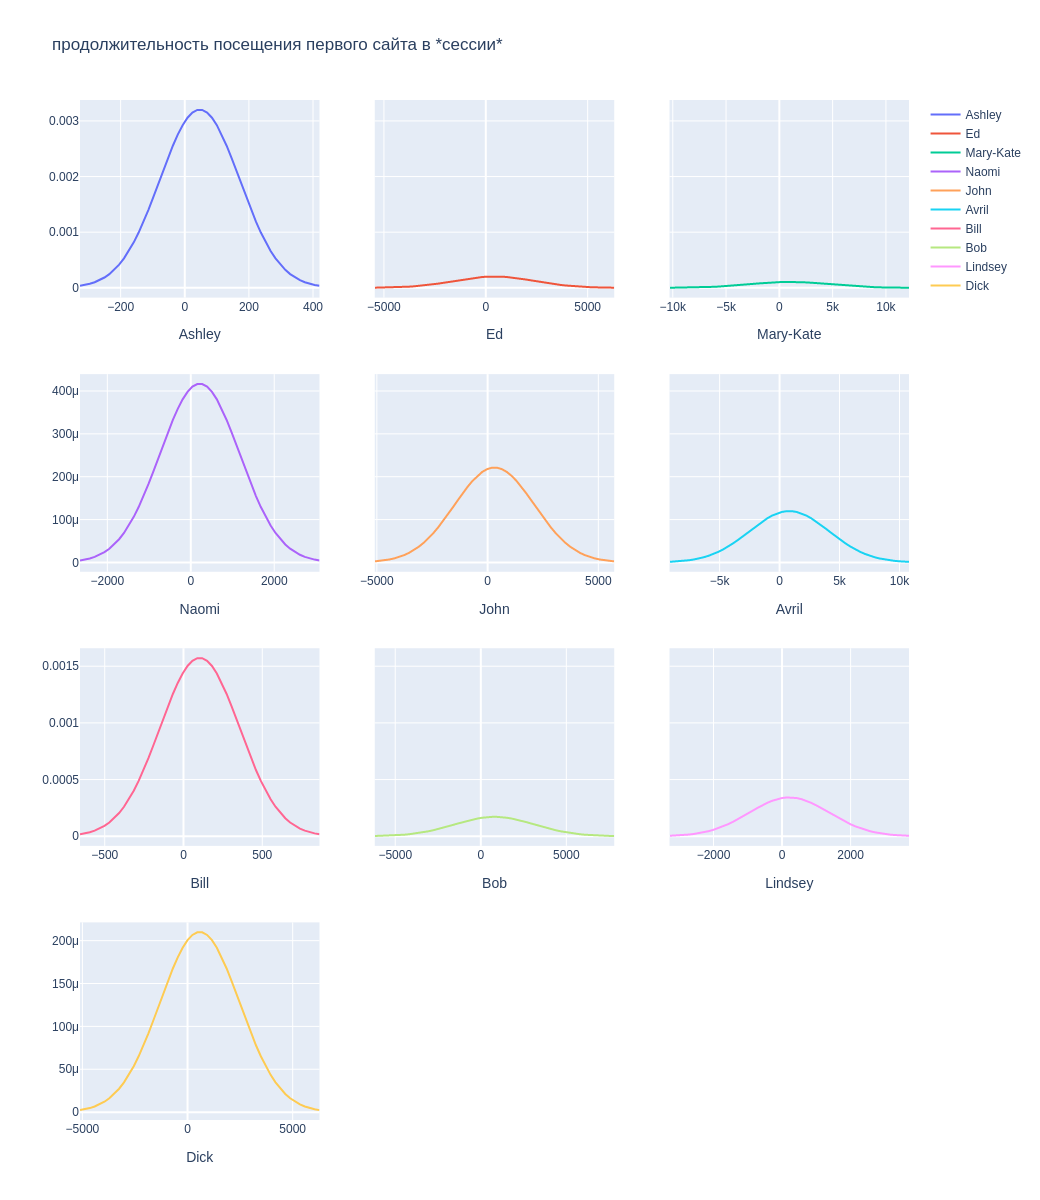

In [45]:
fig10 = make_subplots(rows=4, cols=3, shared_yaxes=True)

for el in itertools.product(range(3), repeat = 2):
    fig10 = subplot_features_points(fig10, new_data, 
                'first_sess_site_duration', 
                idx = el[0]*3 + el[1],
                row = el[0], col = el[1]
                )
    
fig10 = subplot_features_points(fig10, new_data, 
                'first_sess_site_duration', 
                idx = 9, row = 3, col = 0
                )

fig10.update_layout(height=1200, width=1000, 
                    title_text=u'продолжительность посещения первого сайта в *сессии*'
                    ) 
fig10.show()

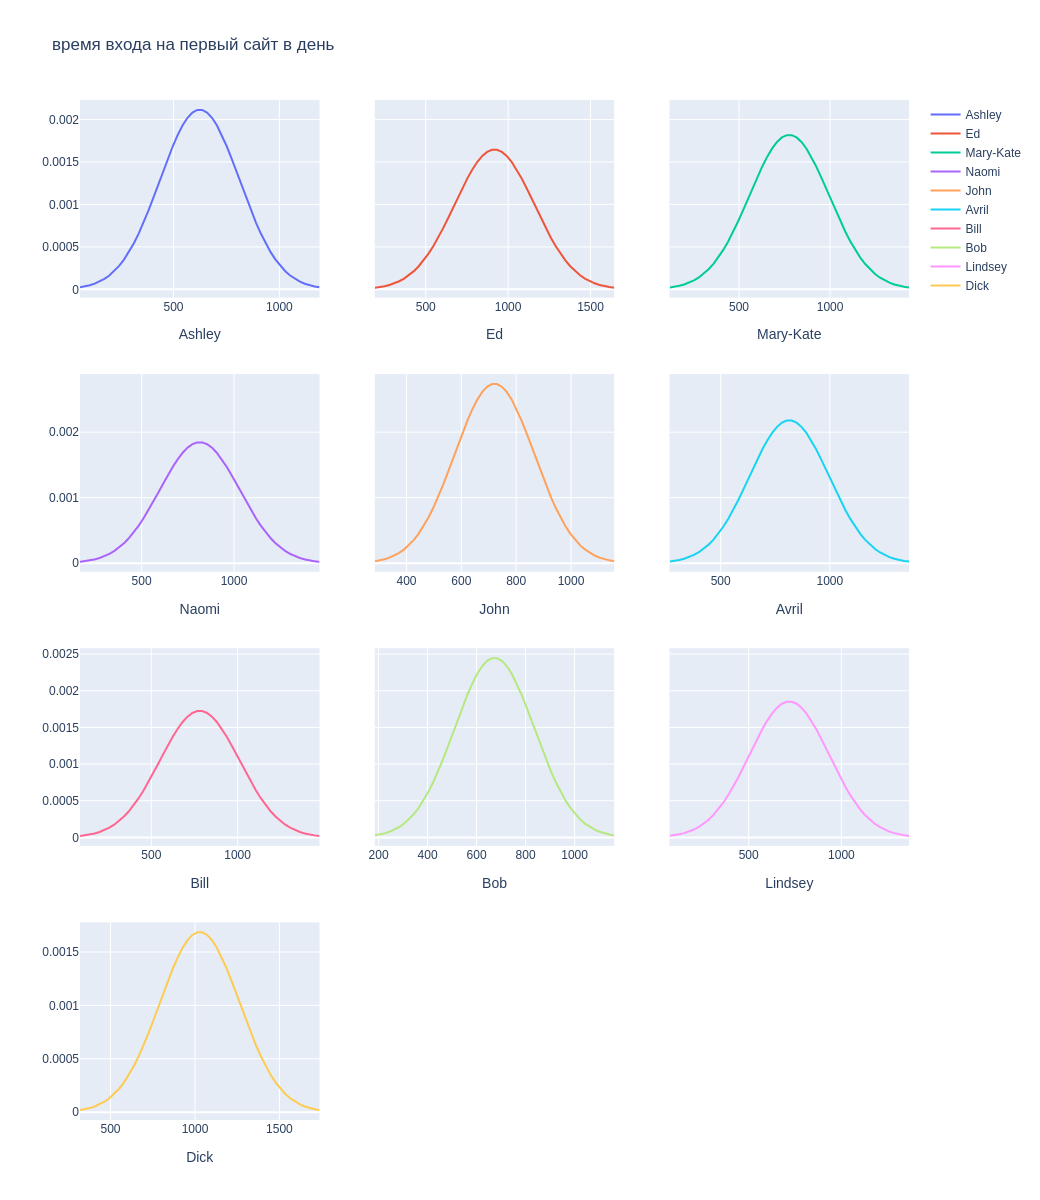

In [46]:
fig10 = make_subplots(rows=4, cols=3, shared_yaxes=True)
#fig10 = make_subplots(rows=4, cols=3)


for el in itertools.product(range(3), repeat = 2):
    fig10 = subplot_features_points(fig10, new_data, 
                'first_connect_in_day_time', 
                idx = el[0]*3 + el[1],
                row = el[0], col = el[1]
                )
    
fig10 = subplot_features_points(fig10, new_data, 
                'first_connect_in_day_time', 
                idx = 9, row = 3, col = 0
                )

fig10.update_layout(height=1200, width=1000, 
                    title_text=u'время входа на первый сайт в день'
                    ) 
fig10.show()

так же наглядно видно, что по расчитанным параметрам пользователи достаточно хорошо разделимы